---
# Introducing `GenericGLM`

This page shows how to implement a simple GLM using the functions embedded in `linescanning.glm`. First, I show how to set up the GLM using the individual functions, which is way too annoying to remember everytime you want to run a glm. For that reason, there's also the `GenericGLM` class, which does everything the individual functions do but then in 1 line of code. Saves some time:). The experiment used in this example was a hemifield-stimulation experiment, so our event conditions are 'left' and 'right'.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# imports
from linescanning import glm, utils
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')
opj = os.path.join

/home/gjheij/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


# Example of `GenericGLM`

In [3]:
# define files
data_path = os.path.dirname(os.path.dirname(glm.__file__))
func_file = opj(data_path, 'examples', 'bold.mat')
exp_file = opj(data_path, 'examples', 'events.tsv')

plot_vox = 359


(2700, 720)


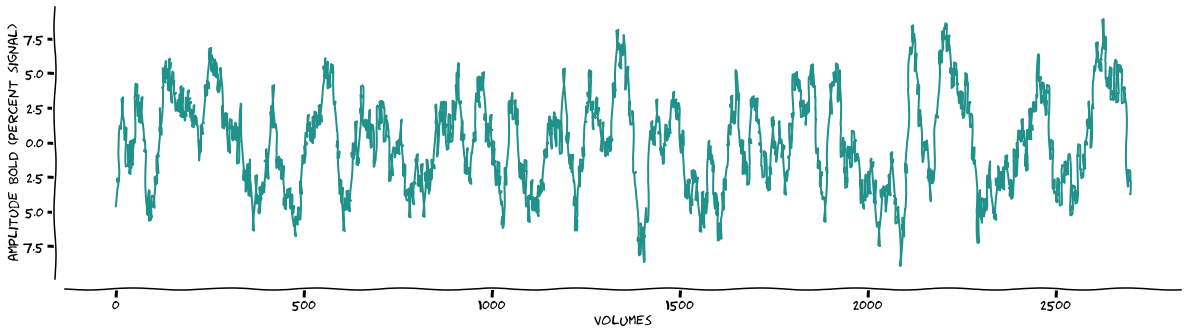

In [4]:
# load in functional data
func = utils.ParseFuncFile(func_file, 
                           subject=1, 
                           run=1, 
                           deleted_first_timepoints=100, 
                           deleted_last_timepoints=0,
                           bp_filter="boxcar") # filter heavily for displaying purposes

# fetch percent signal change
data = func.get_psc(index=True)
print(data.shape)

# plot a timecourse
utils.LazyPlot(data.values[:,plot_vox], figsize=(20,5), font_size=14, x_label="volumes", y_label="amplitude BOLD (percent signal)", xkcd=True)


In [5]:
# load in exptools-file, use attributes from 'func'. 
# All onset times will be corrected for the deleted_first_timepoints by subtracting `deleted_first_timepoints*func.TR` (s) from the onset times
onset = utils.ParseExpToolsFile(exp_file,
                                subject=func.subject,
                                run=func.run,
                                delete_vols=(func.deleted_first_timepoints),
                                TR=func.TR)

# fetch the onset times and event names in a dataframe
onsets = onset.get_onset_df()
onsets.head()


,onset,event_type,subject,run
0,17.461789,right,1,1
1,22.403438,right,1,1
2,26.536976,right,1,1
3,28.311892,right,1,1
4,33.437109,right,1,1


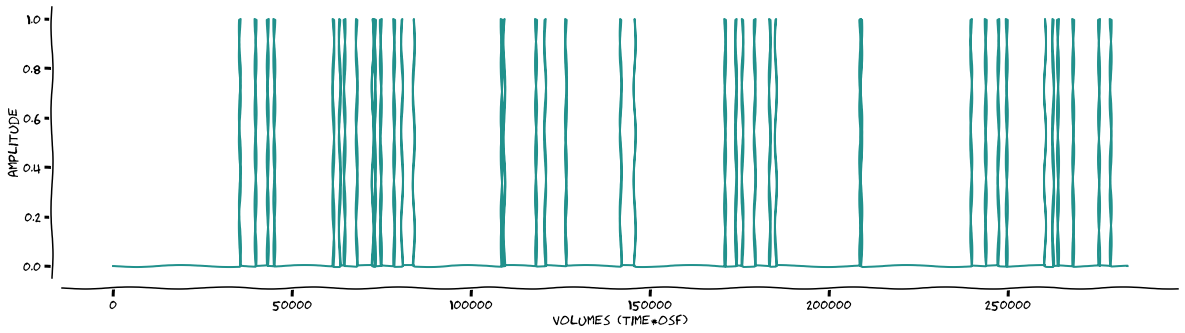

{'left': array([0., 0., 0., ..., 0., 0., 0.]),
 'right': array([0., 0., 0., ..., 0., 0., 0.])}

In [6]:
# oversample with factor 1000 to get rid of 3 decimals in onset times.
# The larger this factor, the more accurate decimal onset times will be processed, but also the bigger your upsampled convolved becomes, which means convolving will take longer.
osf = 1000

# make stimulus vectors
stims = glm.make_stimulus_vector(onsets, scan_length=data.shape[0], osf=osf, type='event')
utils.LazyPlot(stims['left'], figsize=(20,5), font_size=14, x_label="volumes (time*osf)", y_label="amplitude", xkcd=True)
stims

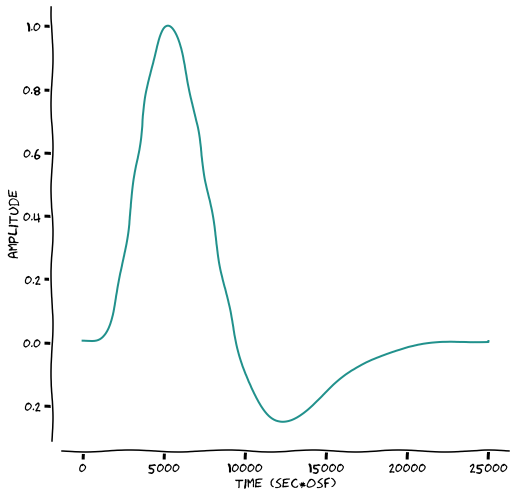

In [7]:
# define HRF
dt = 1/osf
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
hrf = glm.double_gamma(time_points, lag=6)
utils.LazyPlot(hrf, figsize=(8,8), font_size=14, x_label="time (sec*osf)", y_label="amplitude", xkcd=True)


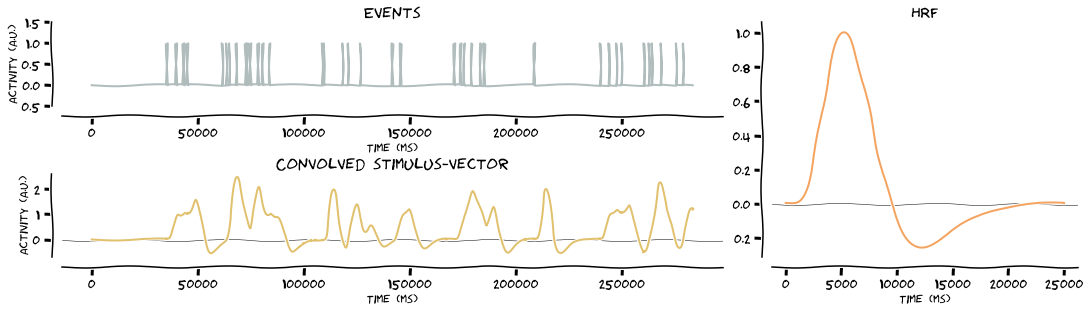

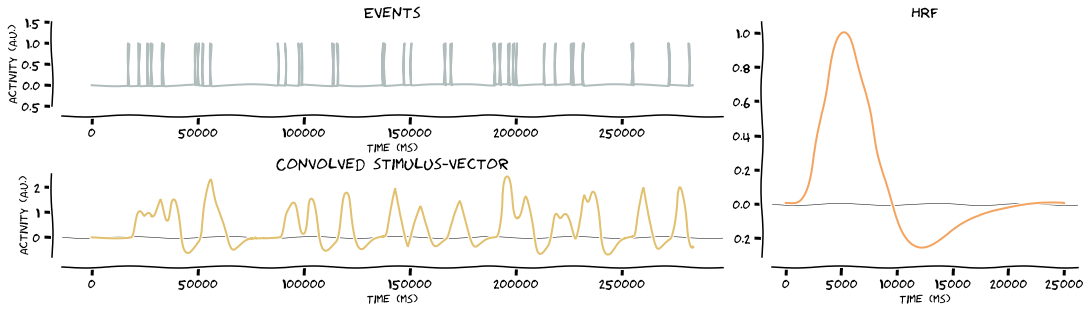

{'left': array([0.   , 0.   , 0.   , ..., 1.189, 1.189, 1.189]),
 'right': array([ 0.   ,  0.   ,  0.   , ..., -0.368, -0.368, -0.368])}

In [8]:
# convolve stimulus vector with HRF
stim_vector = glm.convolve_hrf(hrf, stims, make_figure=True, xkcd=True)
stim_vector

In [9]:
# resample back to time domain of functional data
stim_vector_resampled = glm.resample_stim_vector(stim_vector, data.shape[0])
stim_vector_resampled


{'left': array([0.   , 0.   , 0.   , ..., 1.206, 1.199, 1.189]),
 'right': array([ 0.   ,  0.   ,  0.   , ..., -0.38 , -0.376, -0.368])}

In [10]:
# create design matrix without regressors
design_no_regressors = glm.first_level_matrix(stim_vector_resampled)
design_no_regressors

,intercept,left,right
0,1.0,0.000000,0.000000
1,1.0,0.000000,0.000000
2,1.0,0.000000,0.000000
3,1.0,0.000000,0.000000
4,1.0,0.000000,0.000000
...,...,...,...
2695,1.0,1.210949,-0.375891
2696,1.0,1.209681,-0.379918
2697,1.0,1.205617,-0.380015
2698,1.0,1.198769,-0.376087


In [11]:
# create some fake regressors
regressors = np.zeros((data.shape[0],5))
for ii in range(regressors.shape[-1]):
    regressors[...,ii] = utils.random_timeseries(1.2,(ii/8),data.shape[0])

In [12]:
# create design matrix with regressors
design_regressors = glm.first_level_matrix(stim_vector_resampled, regressors=regressors)
design_regressors


,intercept,left,right,regressor 0,regressor 1,regressor 2,regressor 3,regressor 4
0,1.0,0.000000,0.000000,1.2,1.200000,1.200000,1.200000,1.200000
1,1.0,0.000000,0.000000,1.2,1.376134,0.963021,0.674074,1.795248
2,1.0,0.000000,0.000000,1.2,1.363592,1.058801,1.144742,1.329363
3,1.0,0.000000,0.000000,1.2,1.432665,1.070352,1.278188,1.961027
4,1.0,0.000000,0.000000,1.2,1.060910,0.770531,1.916519,1.302517
...,...,...,...,...,...,...,...,...
2695,1.0,1.210949,-0.375891,1.2,-0.151994,-13.873452,9.166924,0.191214
2696,1.0,1.209681,-0.379918,1.2,-0.162878,-13.412032,8.489787,0.701793
2697,1.0,1.205617,-0.380015,1.2,-0.162691,-13.590188,8.384644,1.079336
2698,1.0,1.198769,-0.376087,1.2,-0.252268,-13.485909,8.078953,0.862818


max tstat (vox 359) = 15.97
max beta (vox 359) = 1.6


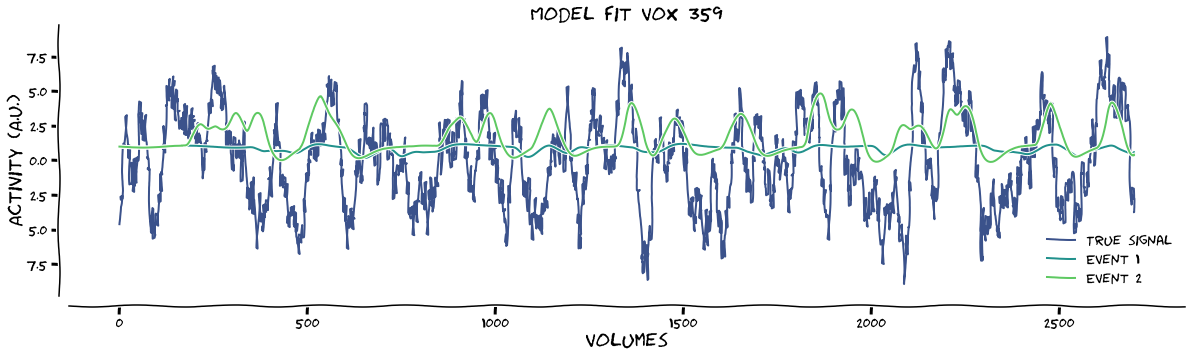

max tstat (vox 359) = 5.97
max beta (vox 359) = 0.07


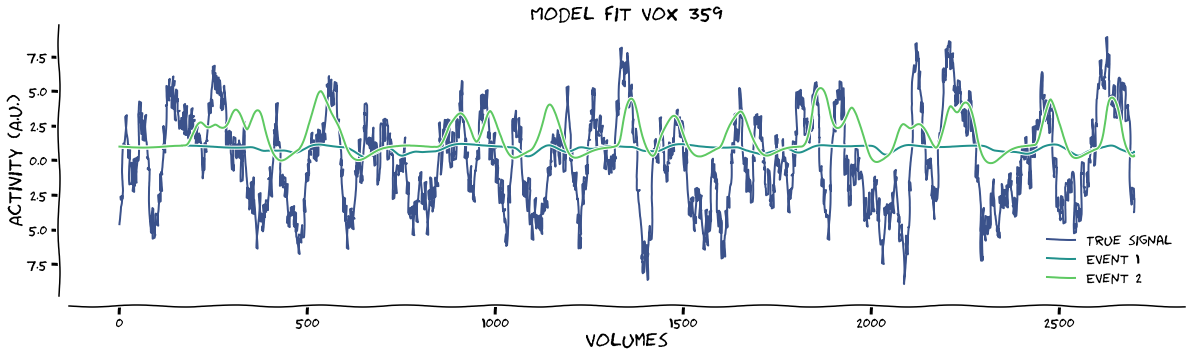

In [13]:
# fit design without regressors + plot first 2 events ('left' & 'right' stimulation)
betas, x_conv = glm.fit_first_level(design_no_regressors, data.values, make_figure=True, xkcd=True, plot_event=[1, 2], plot_vox=plot_vox)

# fit design with regressors + plot first 2 events ('left' & 'right' stimulation)
betas, x_conv = glm.fit_first_level(design_regressors, data.values, make_figure=True, xkcd=True, plot_event=[1,2], plot_vox=plot_vox)


The fact that the betas drop so much after including regressors shows that my fake regressors were really bad. To help with the data structure that comes out of this function, I've printed the shapes of the betas and the design matrix below:

In [14]:
print(f"betas have shape: {betas.shape}")
print(f"design has shape: {x_conv.shape}")

betas have shape: (8, 720)
design has shape: (2700, 8)


Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF


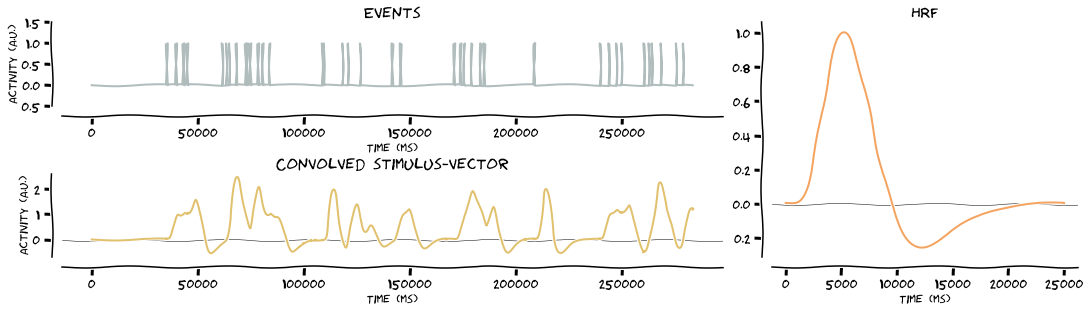

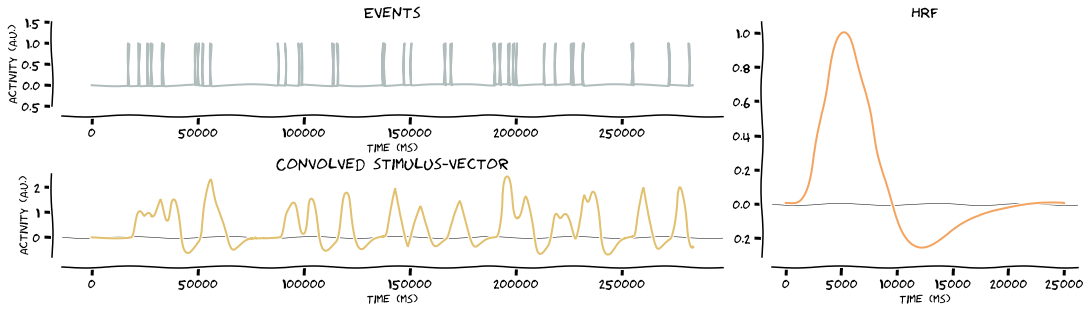

Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 359) = 15.97
max beta (vox 359) = 1.6


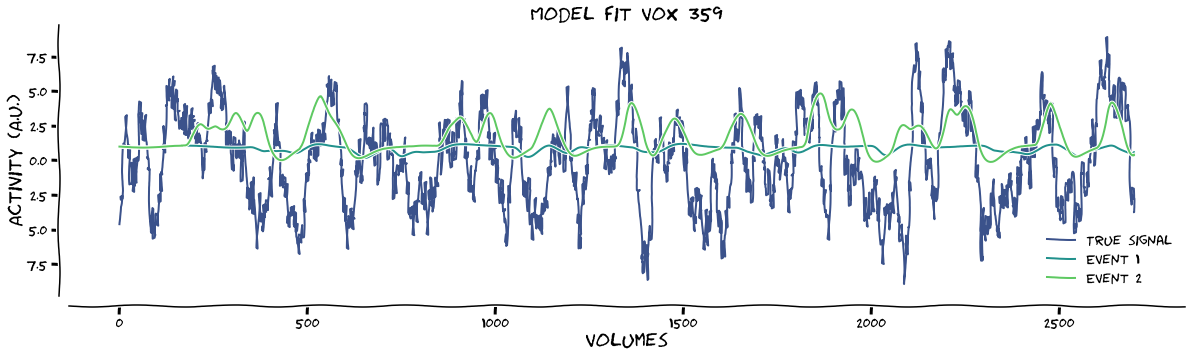

In [15]:
# Now, we can do all of the above much easier with the GenericGLM class. First let's repeat the fitting without regressors
fitting = glm.GenericGLM(onsets, data.values, TR=func.TR, osf=1000, make_figure=True, xkcd=True, verbose=True, plot_vox=plot_vox, plot_event=[1,2])

Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF


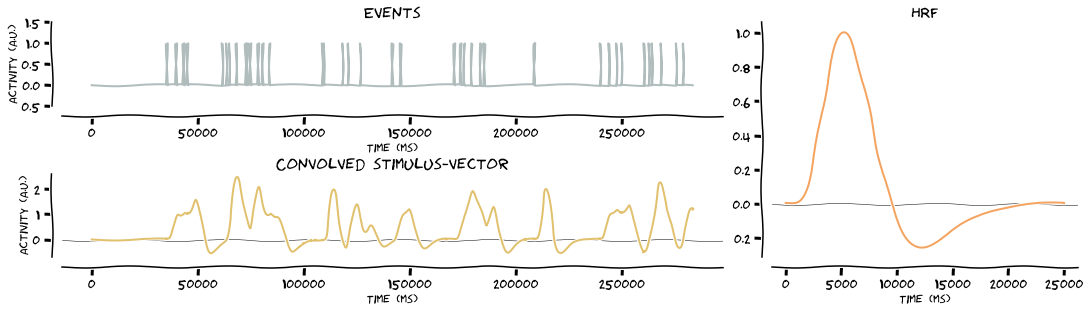

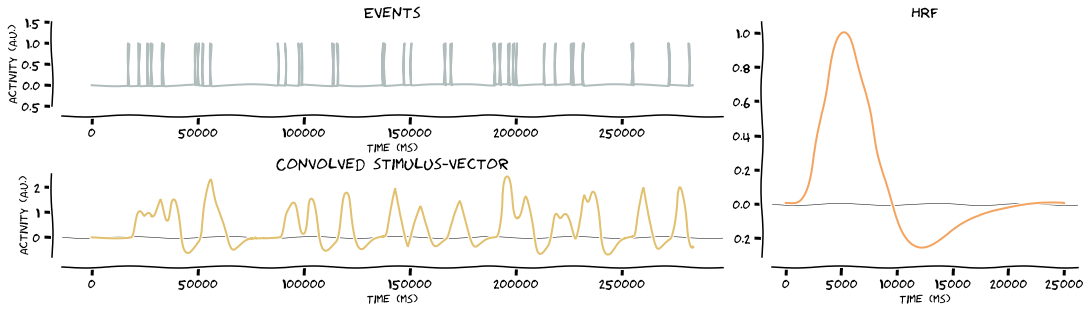

Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 359) = 5.97
max beta (vox 359) = 0.07


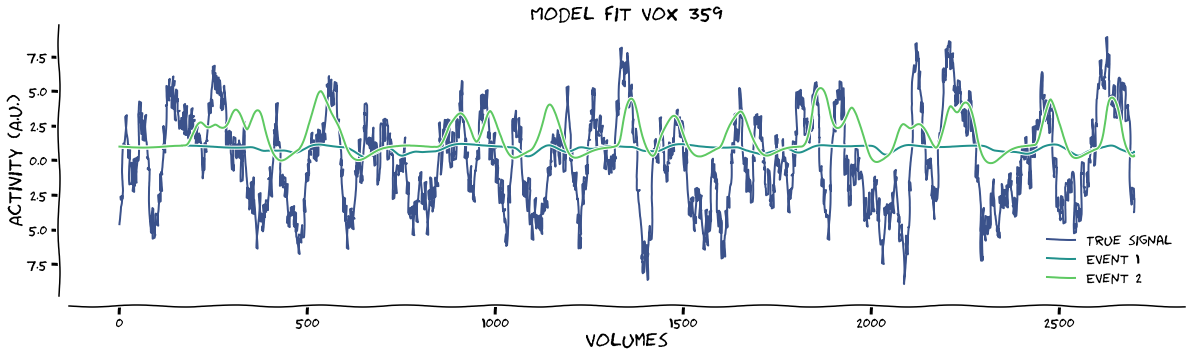

In [16]:
# and the one with regressors
fitting = glm.GenericGLM(onsets, data.values, TR=func.TR, osf=1000, regressors=regressors, make_figure=True, xkcd=True, verbose=True, plot_vox=plot_vox, plot_event=[1,2])

In [17]:
print(f"betas have shape: {fitting.betas.shape}")
print(f"design has shape: {fitting.X_conv.shape}")


betas have shape: (8, 720)
design has shape: (2700, 8)
